In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
np.set_printoptions(precision=3)
import sys
sys.path.append('../../zdrojaky')
from tsplot import tsplot

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import arma_order_select_ic

import warnings
warnings.simplefilter(action='ignore', category=(FutureWarning, DeprecationWarning))

# Modelování časové řady COVID-19 pomocí ARMA modelu

*Zdroj dat: https://onemocneni-aktualne.mzcr.cz/api/v3/docs*

In [2]:
#fn = 'https://onemocneni-aktualne.mzcr.cz/api/v1/covid-19/nakazeni-vyleceni-umrti-testy.csv'
fn = 'nakazeni-vyleceni-umrti-testy.csv'
data = pd.read_csv(fn, index_col=0, parse_dates=True, infer_datetime_format=True)
data.tail()

,kumulativni_pocet_nakazenych,kumulativni_pocet_vylecenych,kumulativni_pocet_umrti,kumulativni_pocet_testu,kumulativni_pocet_ag_testu,prirustkovy_pocet_nakazenych,prirustkovy_pocet_vylecenych,prirustkovy_pocet_umrti,prirustkovy_pocet_provedenych_testu,prirustkovy_pocet_provedenych_ag_testu,kumulativni_pocet_nove_nakazenych_primoinfekce,kumulativni_pocet_nove_nakazenych_reinfekce,prirustkovy_pocet_nove_nakazenych_primoinfekce,prirustkovy_pocet_nove_nakazenych_reinfekce
datum,,,,,,,,,,,,,,
2024-10-02,4788972,4733325,43605,22258838,35297777,1221,98,2,472,4222,4321223,467749,643,578
2024-10-03,4790082,4735199,43608,22259318,35301644,1110,1874,3,480,3867,4321837,468245,614,496
2024-10-04,4791279,4736526,43608,22259780,35305270,1197,1327,0,462,3626,4322489,468790,652,545
2024-10-05,4791366,4737842,43609,22259867,35305466,87,1316,1,87,196,4322550,468816,61,26
2024-10-06,4791460,4738962,43609,22259965,35305679,94,1120,0,98,213,4322603,468857,53,41


Zaměříme se na přírůstkový počet provedených antigenních testů v několika posledních týdnech. Mají data nějaké význačné vlastnosti?

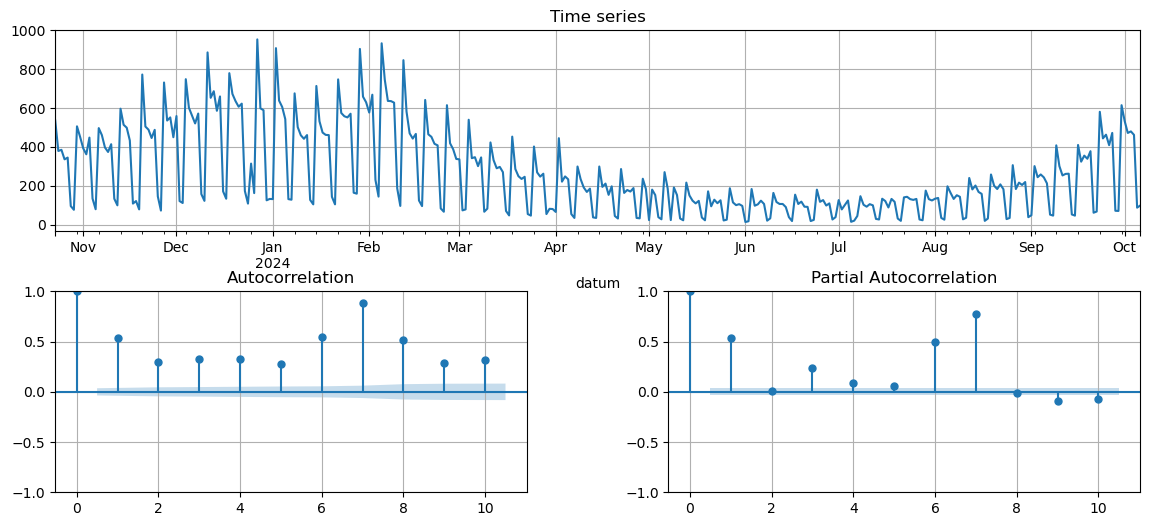

In [3]:
df = data['prirustkovy_pocet_provedenych_testu'].last('50W')
df = df.asfreq('D')

tsplot(df, lags=10)

Jelikož jsme se zatím neseznámili s problematikou sezónnosti, budeme pracovat na týdenních součtech. To může být dokonce vhodné, neboť tím dostáváme poměrně rozumná data, která nevyžadují komplexní model a současně dokážou schovat různé anomálie. Podobně může být praktické pracovat na průměrech apod. Zároveň si vybereme jen podmnožinu z celých dat, kterou použijeme na fitování modelu.

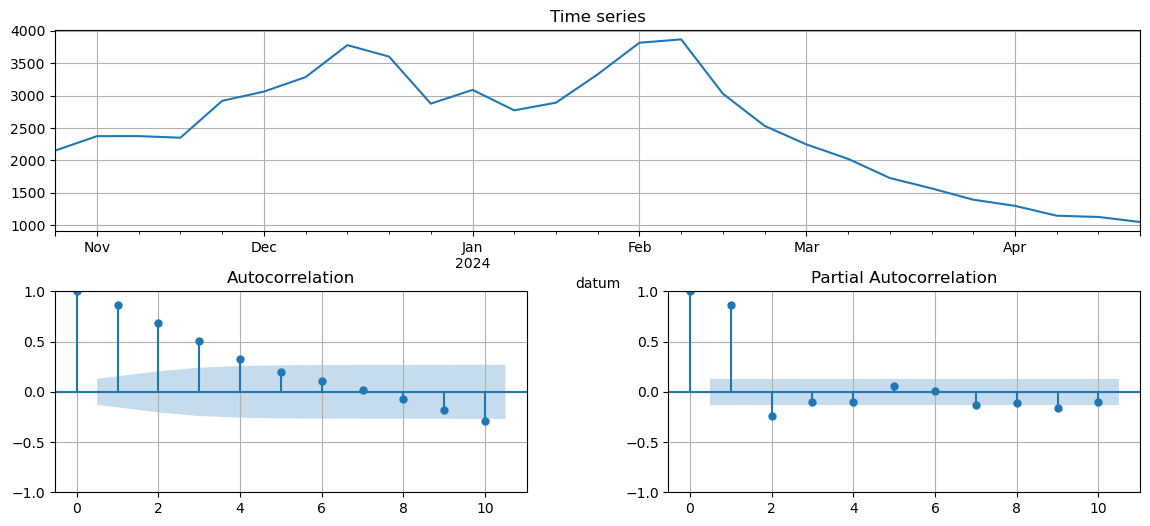

In [4]:
df_analysis_full = df.resample('W').sum()
analysis_to_date = '2024-05-01'
df_analysis = df_analysis_full.loc[:analysis_to_date]
tsplot(df_analysis, lags=10)

Zkusme nyní nějak uhodnout, jaký ARMA model by mohl být vhodný. K tomu nám může posloužit funkce `arma_order_select_ic()`, podobná funkci `ar_select_order()` z minulého cvičení:

In [5]:
arma_order_select_ic(df_analysis, ic='bic', trend='n')

/home/jp/miniconda3/envs/fit/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/jp/miniconda3/envs/fit/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


{'bic':             0           1           2
 0  505.508248  475.877582  454.838748
 1  401.922653  401.652943  404.936000
 2  402.053419  404.927466  407.823155
 3  405.164285  407.781187  411.070246
 4  408.345721  411.326320  414.000258,
 'bic_min_order': (1, 1)}

Měli bychom samozřejmě ozkoušet i varianty s/bez offsetu, popř. si pohrát i s volbou kritérií. To teď vynecháme.

Zkusme nafitovat model. Ačkoliv chceme ARMA, použijeme ARIMA, protože ve statsmodels jsou tyto modely v jedné třídě. Časem poznáme proč.

In [6]:
model = ARIMA(df_analysis, order=(1,0,1), trend='n')
res = model.fit()
print(res.summary())

                                        SARIMAX Results                                        
Dep. Variable:     prirustkovy_pocet_provedenych_testu   No. Observations:                   27
Model:                                  ARIMA(1, 0, 1)   Log Likelihood                -195.883
Date:                                 Mon, 07 Oct 2024   AIC                            397.765
Time:                                         17:28:58   BIC                            401.653
Sample:                                     10-29-2023   HQIC                           398.921
                                          - 04-28-2024                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9772      0.028     34.912      0.000       0.922       1

## Diagnostika - kritéria a obrázky

Minule jsme se seznámili s informačními kritérii AIC a BIC. Zajímat by nás dále mohly různé metriky, jako střední kvadratická chyba predikce ([MSE](https://en.wikipedia.org/wiki/Mean_squared_error)) a střední absolutní chyba predikce ([MAE](https://en.wikipedia.org/wiki/Mean_absolute_error)). Označíme-li $y_t$ skutečnou pozorovanou hodnotu veličiny v čase $t$ na horizontu $T$, $\hat{y}_t$ její modelem predikovanou hodnotu a reziduum $\tilde\varepsilon_t = \hat{y}_t - y_t$, potom

$$
\operatorname{MSE} = \frac{1}{T} \sum_{t=1}^t \tilde\varepsilon_t^2, \qquad \operatorname{MAE} = \frac{1}{T} \sum_{t=1}^T |\tilde\varepsilon_t|.
$$

Ve `statsmodels` na to máme vlastnosti `mae` a `mse`. Pro úplnost doplňme, že rezidua jsou ve vlastnosti `resid` a že `sse` obsahuje "sum of squared errors", tedy sumu kvadrátů reziduí:

In [7]:
print(f'MAE = {res.mae:.4f}')
print(f'MSE = {res.mse:.4f}')

MAE = 316.1129
MSE = 269219.3592


Diagnostické obrázky známe z minule, ale popišme si je tentokrát podrobněji:

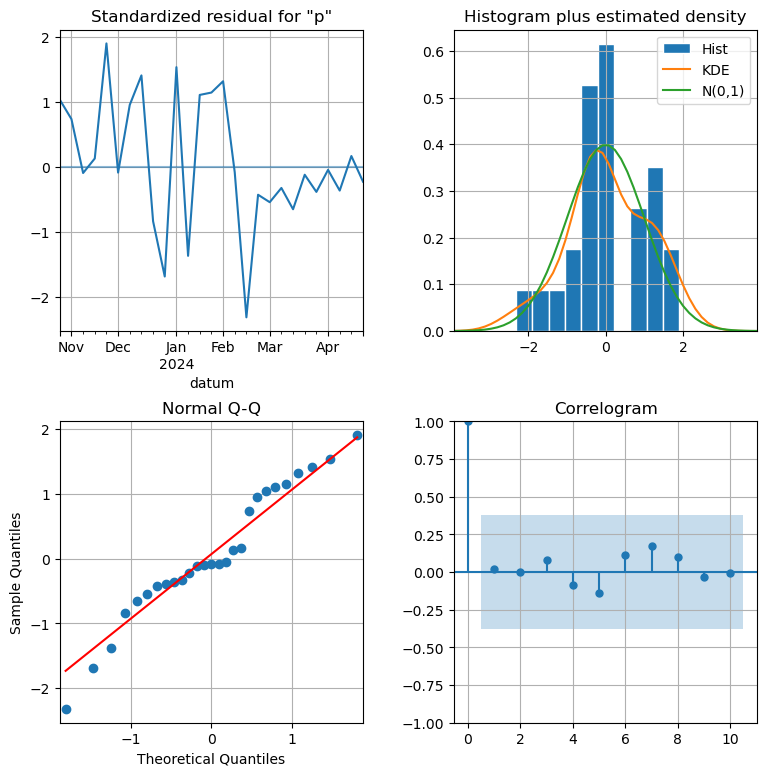

In [8]:
res.plot_diagnostics(figsize=(9,9))
plt.show()

Metoda `plot_diagnostics()` vykreslí:
- vývoj standardizovaných rezidui, tj. chyb predikce po odečtení průměru a vydělení směrodatnou odchylkou. Neradi bychom viděli trend nebo nějaké "vzory";
- histogram standardizovaných reziduí spolu s jádrovým (KDE) odhadem a hustotou $\mathcal{N}(0,1)$, které bychom se rádi co nejvíce přiblížili;
- [Q-Q plot](https://en.wikipedia.org/wiki/Q%E2%80%93Q_plot) zobrazující podobu kvantilů rozdělení $\mathcal{N}(0,1)$ a našich reziduí. Ideálem je, aby body ležely na úhlopříčce;
- Korelogram - už známou ACF reziduí.

## Diagnostika - testy

**Nejprve o testech obecně, potom si aplikujte novou znalost na výsledek z modelování časové řady výše.**

Připomeňme si letem světem základní princip testování hypotéz. Zavádíme:
- **nulovou hypotézu** $H_0$ - základní hypotéza, její platnost chceme v ideálním případě zamítnout (*reject*).
- **alternativní hypotézu** $H_1$ či $H_A$ - zamítáme-li $H_0$, pak ve prospěch této hypotézy.

V případě analýzy časových řad jsou testy zpravidla **oboustranné**, kde $H_0$ říká, že hodnota testovaného parametru je rovna nějakému číslu, proti $H_1$ která předpokládá nerovnost. Připomeňme, že jednostranné testy by tvrdily, že hodnota parametru je buď větší (pravostranný test), nebo menší (test levostranný).

Jsou dva možné výsledky statistického testu:
- **zamítáme $H_0$** (ve prospěch hyp. alternativní) - tj. máme dostatek statistických důkazů (evidence) v její neprospěch. Anglicky: *reject $H_0$*.
- **nezamítáme $H_0$** - nemáme dostatek statistických důkazů proti její platnosti. Tím ale $H_0$ nepotvrzujeme!!! Anglicky: *fail to reject $H_0$*.

Testování provádíme na hladině testu (též významnosti) $\alpha\in[0,1]$, zpravidla 0.05 či nižší. Tato hladina nám říká, jaká je pravděpodobnost, že $H_0$ bude neoprávněně zamítnuta.

Testování je založeno na testové statistice s obvykle nějakým známým vhodným rozdělením (typicky Studentovým $t$ apod.). Za platnosti $H_0$ nabývá tato veličina hodnost z nějakého oboru (vzpomeňte intervaly spolehlivosti) s pravděpodobností $1-\alpha$ a s pravděpodobností $\alpha$ potom z oboru kritického. Pokud hodnota statistiky leží v kritickém oboru, $H_0$ zamítáme.

Software zpravidla počítá **p-hodnotu**, tj. pravděpodobnost, že by testovací statistika dosáhla své hodnoty či hodnot ještě více svědčících proti $H_0$ při platnosti $H_0$. Z wikipedie:

> p-value is the probability of obtaining test results at least as extreme as the results actually observed, under the assumption that the null hypothesis is correct.

#### Z-test koeficientů

Test ověřuje nenulovost jednotlivých koeficientů modelu, např. pro ARMA(1,0) máme hypotézu o AR koeficientu $\phi_1$ v 1. zpoždění v podobě

$$
\begin{aligned}
H_0&: \phi_1 \equiv \text{AR.L1} = 0, \\
H_1&: \phi_1 \equiv \text{AR.L1} \ne 0.
\end{aligned}
$$

Test počítá $Z$ statistiku, $p$-hodnotu a $(1-\alpha)\%$ interval spolehlivosti pro příslušné koeficienty. Zajímají nás především nejvyšší koeficienty modelu, např. pro ARMA(2, 3) by to byly $\phi_2$ a $\theta_3$. Pokud nevychází nejvyšší koeficient statisticky významně odlišný od 0, tj. nezamítáme $H_0$, zkoušíme model zjednodušit vypuštěním příslušného parametru (rozmyslete!).

#### Ljungův-Boxův Q test
Test ověřuje nekorelovanost časové řady, v případě výsledku fitování jde o nekorelovanost standardizovaných reziduí (chyb predikce):

$$
\begin{aligned}
H_0&: \text{data jsou nekorelovaná (no autocorrelation)}, \\
H_1&: \text{neplatí $H_0$}.
\end{aligned}
$$

Testová statistika pro $n$ dat, zpoždění $k$ a výběrový autokorelační koeficient $r_k$ má na horizontu testování $h$ podobu

$$
Q = n(n+2) \sum_{k=1}^h \frac{r_k^2}{n-k} \sim \chi_{h}^2.
$$

Při testování nekorelovanosti reziduí z modelu ARIMA(p, 0, q) je počet stupňů volnosti $h-p-q$. Jednodušší variantou je Boxův-Pierceův test, který `statsmodels` rovněž umí.

#### Test heteroskedasticity

Test ověřuje, zda jsou standardizovaná rezidua (chyby regrese) heteroskedastická, tj. mají proměnnou varianci:

$$
\begin{aligned}
H_0&: \text{rezidua nejsou heteroskedastická (no heteroskedasticity)}, \\
H_1&: \text{neplatí $H_0$}.
\end{aligned}
$$

V implementaci se rozdělí data na tři třetiny a testuje se, zda je součet kvadrátů reziduí v dřívější třetině větší než součet kvadrátů reziduí v pozdější třetině. Označme $h=\lfloor n/3 \rfloor$ kde $n$ je počet dat, $d$ počet zahozených počátečních (burn-in) reziduí a rezidua $\tilde\varepsilon_t$;   testovací statistika má podobu

$$
H(h) = \frac{\sum_{t=n-h+1}^n \tilde\varepsilon_t^2}{\sum_{t=d+1}^{d+1+h} \tilde\varepsilon_t^2} \sim F_{h,h}.
$$

Jde tedy o [Fisherův $F$-test](https://en.wikipedia.org/wiki/F-test_of_equality_of_variances).

#### Jarque-Bera test

Test ověřuje složenou hypotézu, že data mají výběrovou [šikmost](https://en.wikipedia.org/wiki/Skewness) $g_1=0$ a výběrovou [špičatost](https://en.wikipedia.org/wiki/Kurtosis) $g_2=3$, stejně jako normální rozdělení:

$$
\begin{aligned}
H_0&: \text{rezidua mají $g_1=0, g_2=3$}, \\
H_1&: \text{neplatí $H_0$}.
\end{aligned}
$$

Testová statistika je asymptoticky $\chi^2$ rozdělená, pro $n$ dat má podobu

$$
JB = \frac{n}{6}\left(g_1^2 + \frac{(g_2 - 3)^2}{4}\right) \sim \chi_2^2.
$$

Pro malé rozsahy výběru se nutné využívat lepší aproximace, neboť $\chi^2$ aproximace není dostatečná. V implementaci se podobně jako u předešlého testu vynechává určitý počet počátečních dat (reziduí).

## Predikce

Kreslení predikcí bohužel není tak jednoduché, jako s `AutoReg`. Nejprve si musíme predikce napočítat:

In [9]:
preds_to_date = '2024-11-01'
preds = res.get_prediction(end=preds_to_date)
preds.summary_frame().head()

prirustkovy_pocet_provedenych_testu,mean,mean_se,mean_ci_lower,mean_ci_upper
2023-10-29,0.000000,2079.433658,-4075.615078,4075.615078
2023-11-05,2122.765324,341.592307,1453.256705,2792.273943
2023-11-12,2405.644724,321.643161,1775.235713,3036.053736
2023-11-19,2309.058208,318.928295,1683.970237,2934.146179
2023-11-26,2312.460683,318.516930,1688.178972,2936.742393


...a následně můžeme kreslit:

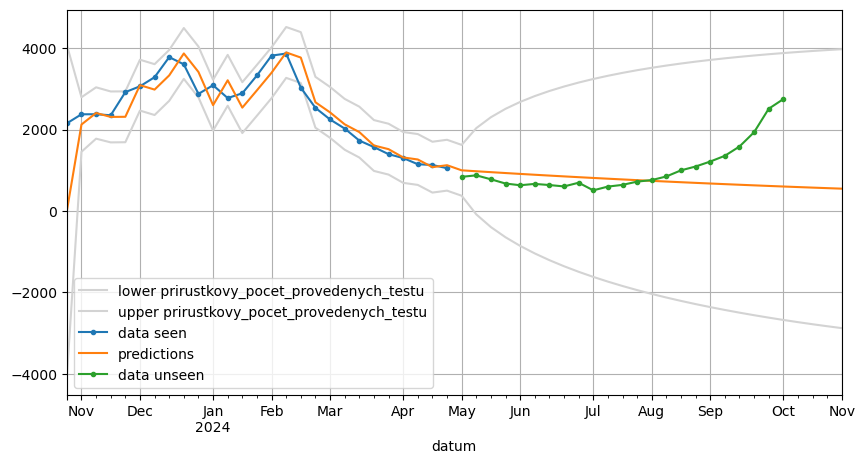

In [13]:
ci = preds.conf_int()

fig = ci.plot(color='lightgrey', figsize=(10, 5))
res.data.orig_endog.plot(label='data seen', marker='.', fig=fig)
preds.predicted_mean.plot(label='predictions', fig=fig)
df_analysis_full[analysis_to_date:].plot(label='data unseen', marker='.', fig=fig)
plt.legend()
plt.show()